ATM

In [1]:
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Markdown as md

import seaborn as sns
from tsfresh.feature_extraction import settings
from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import (
    impute,
    make_forecasting_frame,
    roll_time_series,
)
from tsfresh.feature_extraction import (
    ComprehensiveFCParameters,
    MinimalFCParameters,
    EfficientFCParameters,
    settings,
)
from sklearn.model_selection import train_test_split

from sklearn.metrics import (
    max_error as ME,
    mean_absolute_error as MAE,
    mean_absolute_percentage_error as MAPE,
)

from sklearn.preprocessing import StandardScaler

mypath = "./Datasets/wisabi"
files = [
    join(mypath, f)
    for f in listdir(mypath)
    if isfile(join(mypath, f)) and "transactions.csv" in f
]
files

['./Datasets/wisabi/enugu_transactions.csv',
 './Datasets/wisabi/fct_transactions.csv',
 './Datasets/wisabi/kano_transactions.csv',
 './Datasets/wisabi/lagos_transactions.csv',
 './Datasets/wisabi/rivers_transactions.csv']

In [2]:
dfs = list(zip(map(pd.read_csv, files), files))

In [3]:
full_calendar = pd.read_csv(mypath+'/calendar lookup.csv', index_col='Date')
full_calendar.index = pd.to_datetime(full_calendar.index)
cols = ['IsHoliday','Day Name']
calendar  = full_calendar[cols]
calendar = pd.get_dummies(calendar,drop_first=True)
# calendar

In [4]:
import multiprocessing
pool = multiprocessing.Pool()


def transactions_to_cash_ts(args):
    df, file = args
    for c in ["TransactionStartDateTime", "TransactionEndDateTime"]:
        df[c] = pd.to_datetime(df[c])
    df = df.drop(columns=["CardholderID", "LocationID"])
    df = df[df.TransactionTypeID.isin([1, 2])]
    df["date"] = df.TransactionStartDateTime.dt.date  # .round("H")
    df.drop(
        columns=["TransactionStartDateTime", "TransactionEndDateTime"], inplace=True
    )
    df.loc[df.TransactionTypeID == 2, "TransactionAmount"] *= -1
    df = df.drop(columns="TransactionTypeID")
    ts = df.groupby("date").sum().TransactionAmount
    # ts = pd.Series(df.TransactionAmount, index = df.date)
    ts.name = file.split("/")[-1].split(".")[0]
    # ts = ts.to_frame()#.merge(calendar, left_index=True, right_index=True)
    return ts

In [5]:
# transactions_to_cash_ts(dfs[0])

In [6]:
tss = list(map(transactions_to_cash_ts, dfs))


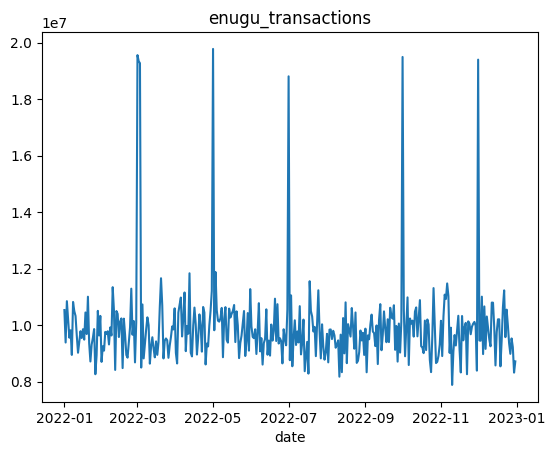

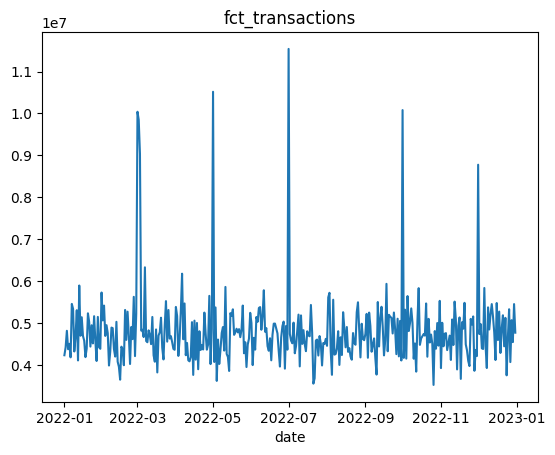

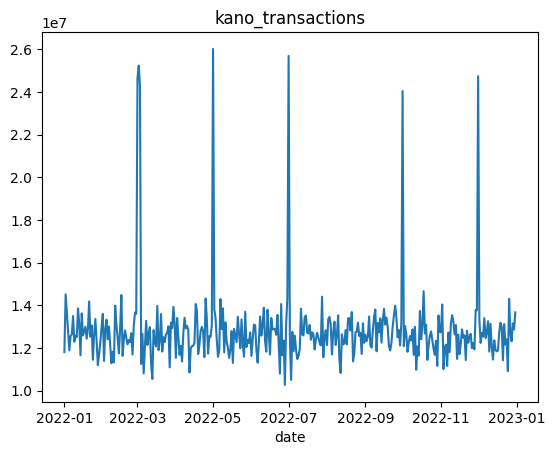

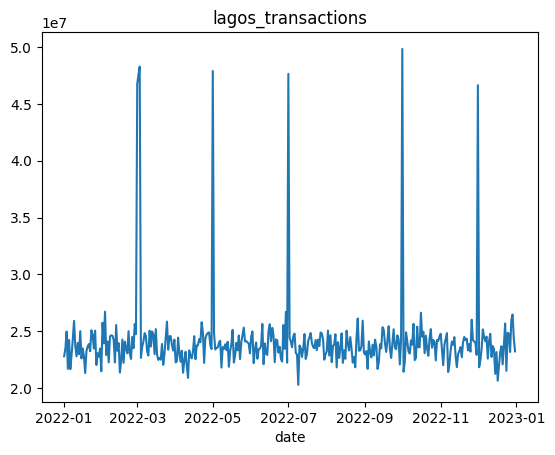

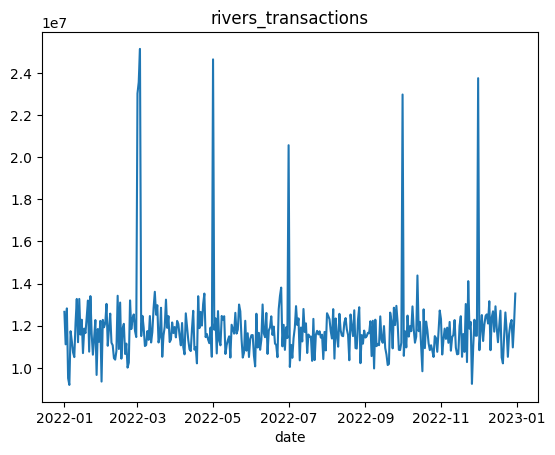

In [7]:
for ts in tss:
    ts.plot()
    plt.title(ts.name)
    plt.show()

Extraction settings

In [8]:
# extraction_settings = EfficientFCParameters()
extraction_settings = ComprehensiveFCParameters()
del extraction_settings["friedrich_coefficients"]
del extraction_settings["max_langevin_fixed_point"]
# extraction_settings = MinimalFCParameters()

horizon = 1


In [9]:
def ts_to_train_test(ts_inp, best_features=None):
    ts = ts_inp.diff().dropna()
    med = ts.median()  # TODO более аккуратно
    ts.loc[ts.sort_values().head(7).index] = med
    ts.loc[ts.sort_values().tail(7).index] = med
    common_name = "transaction"

    scaler = StandardScaler()
    ts_scaled = pd.Series(
        scaler.fit_transform(ts.values.reshape(-1, 1)).reshape(-1),
        index=ts.index,
        name=common_name#ts.name,
    )
    ts = ts_scaled
    dfts = ts.to_frame()
    dfts["id"] = common_name#ts.name
    dfts.reset_index(inplace=True)
    df_rolled = roll_time_series(
        dfts, column_id="id", column_sort="date", max_timeshift=20, min_timeshift=5
    )
    # каждый момент времени описываем окном длины не больше 20, окна длины меньше чем 5 отбрасываем
    name = ts.name
    X = extract_features(
        df_rolled,
        column_id="id",
        column_sort="date",
        column_value=common_name,#name,
        impute_function=impute,
        show_warnings=False,
        default_fc_parameters=extraction_settings,
    )
    X = X.set_index(X.index.map(lambda x: x[1])).copy()
    X[name] = ts[X.index]  # добавялем оригинальный ряд
    X["y"] = X[name].shift(-horizon)
    # # добавляем target - оригинальный ряд смещенный на 1 в будущее
    df = X.dropna().copy()
    
    df = df.merge(calendar, left_index=True, right_index=True)
    y = df.y
    df.drop("y", axis=1, inplace=True)
    X = df
    if best_features is not None:
        X = X[best_features]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, shuffle=False)
    return X_train, X_test, y_train, y_test

In [10]:
# fig = go.Figure()
# fig.add_trace(go.Scatter(x=ts.index, y=ts))

In [11]:
# X_train_selected = select_features(X_train, y_train)
# best_features=X_train_selected.columns
# md(f"#### Отобрали фичей: {len(best_features)}")

Best features

In [12]:
X_train, X_test, y_train, y_test = ts_to_train_test(tss[0])
X_train_selected = select_features(X_train, y_train)
best_features=X_train_selected.columns
len(best_features)

Feature Extraction: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


38

#### Boosting

In [13]:
# from catboost import CatBoostRegressor



# model = CatBoostRegressor(silent=True).fit(X_train, y_train)
# y_pred = pd.Series(model.predict(X_test), index=X_test.index)

In [14]:
# y_pred_dumb = y_test.shift(1)
# MAE(y_test[1:], y_pred_dumb[1:]),MAE(y_test, y_pred)

Boosting plot

In [15]:
# fig = go.Figure()
# fig.update_layout(title_text=f"CatBoost & tsfresh. MAE={MAE(y_test, y_pred):.4f}")
# fig.add_trace(go.Scatter(x=y_train.index, y=y_train, name="Train"))
# fig.add_trace(go.Scatter(x=y_test.index, y=y_test, name="Test"))
# fig.add_trace(go.Scatter(x=y_pred.index, y=y_pred, name="Predicted"))

#### Torch

In [16]:
from datasets import load_dataset, load_from_disk
import pandas as pd
from transformers import Trainer
from transformers import TrainingArguments
from transformers import EncoderDecoderModel
from transformers import BertTokenizer
import numpy as np
import os
import random
import gc
import torch
import torch.nn as nn
import torch.optim as optim
import shutil
from tqdm import tqdm

torch.cuda.empty_cache()
gc.collect()

SEED = 42


def seed_everything(seed=SEED):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


torch.backends.cudnn.deterministic = True
seed_everything(SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)


model

In [18]:
feat_cnt = len(best_features)#X_train.shape[1]
def get_model():
    model = nn.Sequential(
        nn.Linear(feat_cnt, 10),
        nn.ReLU(),
        nn.Linear(10, 1),
        # nn.ReLU(),
        # nn.Linear(24, 6),
        # nn.ReLU(),
        # nn.Linear(6, 1),
    )
    return model


In [19]:
import copy


epochs = 400  # number of epochs to run
batchSize = 20  # size of each batch

def train(model, X_train, X_test, y_train, y_test):
    lossFunction = nn.MSELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.001)


    X_train = torch.tensor(X_train.values, dtype=torch.float32)
    y_train = torch.tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    X_test = torch.tensor(X_test.values, dtype=torch.float32)
    y_test = torch.tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Hold the best model
    best_mse = np.inf  # init to infinity
    best_weights = None
    history = []
    train_history = []

    
    size = X_train.shape[0]#TODO X?
    # my redone training loop
    for epoch in range(epochs):
        model.train()

        index = 0

        while index * batchSize <= size:
            # take a batch
            X_batch = X_train[index: index + batchSize]
            y_batch = y_train[index: index + batchSize]

            # forward pass
            y_pred = model(X_batch)

            # print(y_pred)
            loss = lossFunction(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

            index += batchSize

        # evaluate accuracy at end of each epoch
        model.eval()
        train_pred = model(X_train)
        train_history.append(float(lossFunction(train_pred, y_train)))
        y_pred = model(X_test)
        mse = lossFunction(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            # print(f"best mse is {mse} on epoch {epoch}")
            best_mse = mse

            # save the best weights
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    return train_history, history

In [20]:
# plt.plot(history)
# plt.title("test MSE evolution by Epoch")
# plt.xlabel("MSE")
# plt.ylabel("Epoch")

Torch plots

In [21]:
# fig = go.Figure()
# fig.update_layout(title_text=f"NNet & tsfresh. MAE={MAE(dfy_test, dfy_pred):.4f}")
# fig.add_trace(go.Scatter(x=dfy_train.index, y=dfy_train, name="Train"))
# fig.add_trace(go.Scatter(x=dfy_test.index, y=dfy_test, name="Test"))
# fig.add_trace(go.Scatter(x=dfy_pred.index, y=dfy_pred, name="Predicted"))

### FL

In [22]:
def avg_models(models):
    models_params = [dict(m.named_parameters()) for m in models]
    res = get_model()

    res_params = dict(res.named_parameters())
    for name1, param1 in res.named_parameters():
        arrays = [param_dict[name1].detach().numpy() for param_dict in models_params]
        res_params[name1].data.copy_(torch.from_numpy(np.mean(arrays, axis=0)))

    res = get_model()
    res.load_state_dict(res_params)
    return res

Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.98it/s]


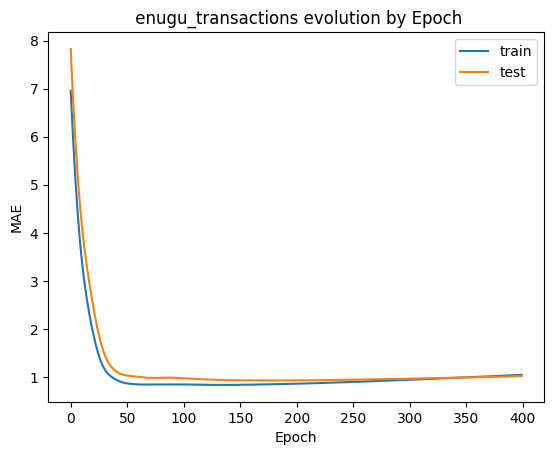

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.15it/s]


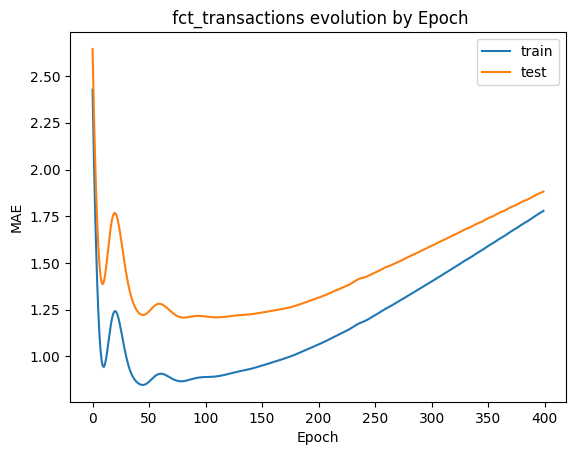

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  2.91it/s]


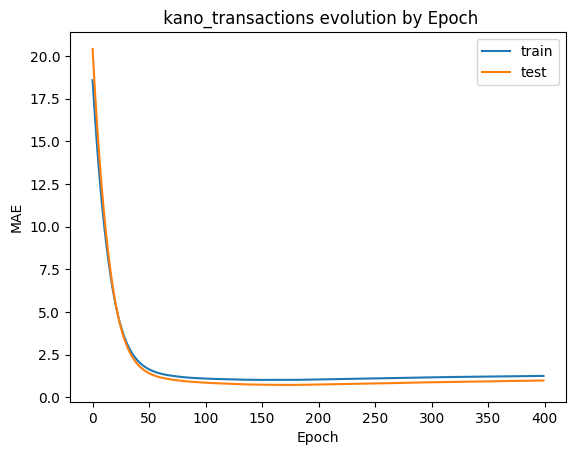

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.28it/s]


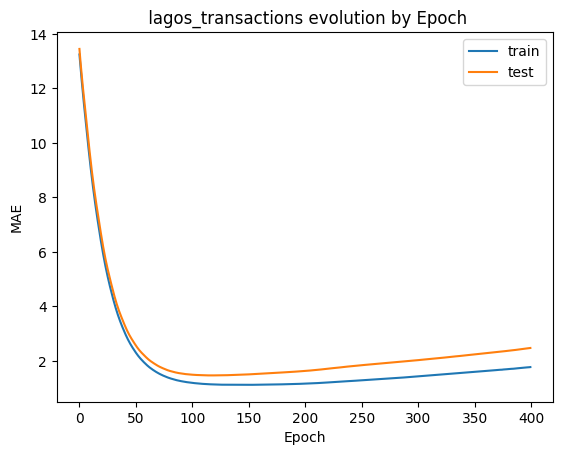

Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.41it/s]


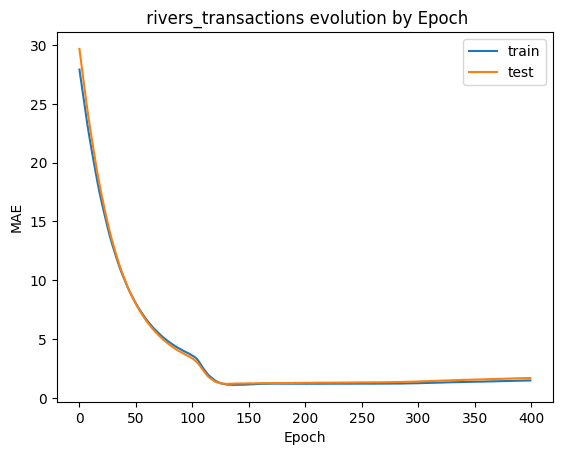

In [23]:
training_result = pd.DataFrame(index = [ts.name for ts in tss], columns=['local', 'aggr'])
models = []
for ts in tss:
    X_train, X_test, y_train, y_test = ts_to_train_test(ts, best_features=best_features)
    model = get_model()
    train_history, history = train(model, X_train, X_test, y_train, y_test)
    models.append(model)
    dfX_train = X_train
    dfX_test = X_test
    dfy_train = y_train
    dfy_test = y_test

    dfy_pred = pd.Series(model(torch.tensor(X_test.values, dtype=torch.float32)).detach(
    ).numpy().reshape(-1), index=dfy_test.index)

    plt.plot(train_history)
    plt.plot(history)
    plt.title(f" {ts.name} evolution by Epoch")
    plt.ylabel("MAE")
    plt.xlabel("Epoch")
    plt.legend(['train', 'test'])
    plt.show()

    mae = MAE(dfy_test, dfy_pred)
    training_result.loc[ts.name, 'local'] = np.round(mae, 2)
    fig = go.Figure()
    fig.update_layout(
        title_text=f" {ts.name} NNet & tsfresh. MAE={mae:.4f}")
    fig.add_trace(go.Scatter(x=dfy_train.index, y=dfy_train, name="Train"))
    fig.add_trace(go.Scatter(x=dfy_test.index, y=dfy_test, name="Test"))
    fig.add_trace(go.Scatter(x=dfy_pred.index, y=dfy_pred, name="Predicted"))
    fig.show()

AVG

In [25]:
avg_model

Sequential(
  (0): Linear(in_features=38, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
avg_model = avg_models(models)
for ts in tss:
    X_train, X_test, y_train, y_test = ts_to_train_test(ts, best_features=best_features)
    # train_history, history = train(avg_model, X_train, X_test, y_train, y_test)
    dfX_train = X_train
    dfX_test = X_test
    dfy_train = y_train
    dfy_test = y_test

    dfy_pred = pd.Series(avg_model(torch.tensor(X_test.values, dtype=torch.float32)).detach(
    ).numpy().reshape(-1), index=dfy_test.index)

    mae = MAE(dfy_test, dfy_pred)
    training_result.loc[ts.name, 'aggr'] = np.round(mae, 2)
    fig = go.Figure()
    fig.update_layout(
        title_text=f" {ts.name} Aggregated NNet & tsfresh. MAE={MAE(dfy_test, dfy_pred):.4f}")
    fig.add_trace(go.Scatter(x=dfy_train.index, y=dfy_train, name="Train"))
    fig.add_trace(go.Scatter(x=dfy_test.index, y=dfy_test, name="Test"))
    fig.add_trace(go.Scatter(x=dfy_pred.index, y=dfy_pred, name="Predicted"))
    fig.show()

Feature Extraction: 100%|██████████| 20/20 [00:06<00:00,  3.18it/s]


Feature Extraction: 100%|██████████| 20/20 [00:05<00:00,  3.90it/s]


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.06it/s]


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.03it/s]


Feature Extraction: 100%|██████████| 20/20 [00:04<00:00,  4.27it/s]


<AxesSubplot: >

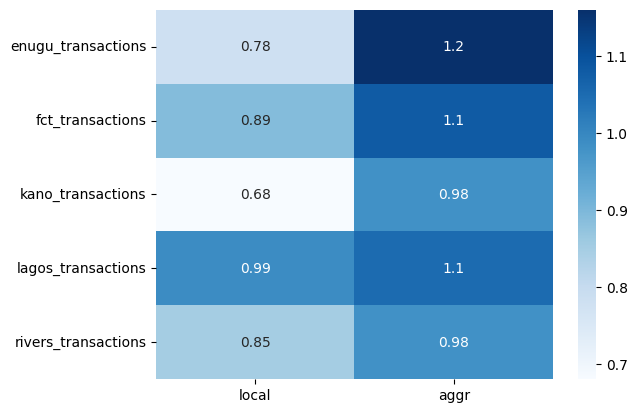

In [27]:
training_result=training_result.astype(float)
sns.heatmap(training_result,cmap="Blues", annot=True)

In [28]:
feat_cnt

38